# LSTM

In [1]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

In [2]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, '--', c=c[0], label='Train loss')
    plt.plot(val_losses, c=c[0], label='Val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(train_accs, '--', c=c[1], label='Train acc')
    plt.plot(val_accs, c=c[1], label='Val acc')
    plt.legend(loc='best')

In [3]:
def plot_CV_learning_curves(K_train_losses, K_val_losses, K_train_accs, K_val_accs):
    plt.figure(figsize=(8,4))
    for train_losses in K_train_losses:
        plt.plot(train_losses, '--', c=c[0], label='Train loss CV', alpha=0.4)
    for val_losses in K_val_losses:
        plt.plot(val_losses, c=c[0], label='Val loss CV', alpha=0.4)
    mean_train_losses = np.array(K_train_losses).mean(axis=0)
    mean_val_losses = np.array(K_val_losses).mean(axis=0)
    plt.plot(mean_train_losses, '--', c=c[0], label='Train loss mean')
    plt.plot(mean_val_losses, c=c[0], label='Val loss mean')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    for train_accs in K_train_accs:
        plt.plot(train_accs, '--', c=c[1], label='Train acc CV', alpha=0.4)
    for val_accs in K_val_accs:
        plt.plot(val_accs, c=c[1], label='Val acc CV', alpha=0.4)
    mean_train_accs = np.array(K_train_accs).mean(axis=0)
    mean_val_accs = np.array(K_val_accs).mean(axis=0)
    plt.plot(mean_train_accs, '--', c=c[1], label='Train acc mean')
    plt.plot(mean_val_accs, c=c[1], label='Val acc mean')
    plt.legend(loc='best')

## 1 Loading and transforming the data

In [4]:
train_input, train_target = bci.load(root = './data_bci', train=True, one_khz=True)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])


In [5]:
test_input, test_target = bci.load(root = './data_bci', train=False, one_khz=True)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [6]:
train_input = train_input.permute(0,2,1)
test_input = test_input.permute(0,2,1)

## 1.1 Standardizing the data

In [7]:
def standardize_data(input_data, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = input_data.contiguous().view(-1, 28).mean(dim=0)
        std_dev = input_data.contiguous().view(-1, 28).std(dim=0)
    return (input_data - mean) / std_dev, mean, std_dev

In [8]:
train_input, mean, std_dev = standardize_data(train_input)
test_input, _, _ = standardize_data(test_input, mean, std_dev)

## 1.2 Data augmentation

In [9]:
def augment_dataset(train_input, train_target, std_dev, multiple):
    new_train_input = train_input.clone()
    new_train_target = train_target.clone()
    for i in range(multiple-1):
        augmented_input = train_input + torch.zeros(train_input.shape).normal_(0, std_dev)
        new_train_input = torch.cat((new_train_input, augmented_input))
        new_train_target = torch.cat((new_train_target, train_target))
    return new_train_input, new_train_target

In [10]:
# Run only if not doing cross validation (it will augment the dataset itself)
train_input, train_target = augment_dataset(train_input, train_target, 0.1, 5)

## 1.3 Creating the Dataset / Dataloader

In [11]:
train_input.shape, test_input.shape

(torch.Size([1580, 500, 28]), torch.Size([100, 500, 28]))

In [12]:
# Run only if not doing cross validation
train_dataset = TensorDataset(train_input, train_target)
test_dataset = TensorDataset(test_input, test_target)

In [14]:
# Run only if not doing cross validation
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
dset_loaders = {'train': trainloader, 'val': testloader}
dset_sizes = {'train': len(train_input), 'val': len(test_input)}

## 2 Defining the model architecture

In [30]:
#seq = train_input.shape[1] # 500
#input_size = train_input.shape[2] #28

class Net(torch.nn.Module):
    def __init__(self, input_size, batch_size, hidden_size=256, num_layers=1, dropout=0.2):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.batch_size = batch_size
        # LSTM input size is: (batch, seq, feature)
        # LSTM output size is: (batch, seq, hidden_size)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_size, 2)

    def forward(self, x, hidden):
        x = self.lstm(x, hidden)[0][:,-1,:] # take only last output of LSTM (many-to-one RNN)
        x = x.view(x.shape[0], -1) # flatten to (batch, hidden_size)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        # Initializing the hidden layer
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        h_0 =torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        if torch.cuda.is_available():
            return (Variable(h_0.cuda()), Variable(c_0.cuda()))
        else:
            return (Variable(h_0), Variable(c_0))

## 3 Training models

In [31]:
def train_model(model, dset_loaders, dset_sizes, criterion, optimizer,\
                lr_scheduler=None, num_epochs=25, verbose=2):
    since = time.time()

    best_model = model
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        if verbose > 1:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler:
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # zero the hidden state
                hidden = model.init_hidden(len(inputs))

                # forward
                outputs = model(inputs, hidden)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                preds_classes = preds.data.max(1)[1]
                running_corrects += torch.sum(preds_classes == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if verbose > 1:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        if verbose > 1: 
            print()

    time_elapsed = time.time() - since
    if verbose > 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
    return best_model, train_losses, val_losses, train_accs, val_accs

In [32]:
def k_fold_cv(model, train_input, train_target, criterion, optimizer, lr_scheduler=None,\
              num_epochs=25, batch_size=64, K=5, verbose=2, augment_multiplier=0, std_dev=0.1):
    n_train = len(train_input)
    indices = list(range(n_train))
    n_validation = n_train // K
    
    np.random.shuffle(indices)
        
    avg_train_loss, avg_val_loss = 0, 0
    avg_train_acc, avg_val_acc = 0, 0
    
    K_train_losses = []
    K_val_losses = []
    K_train_accs = []
    K_val_accs = []
        
    for k in range(K):
        indices_rolled = np.roll(indices, k * n_train // K)
        train_idx, val_idx = indices_rolled[n_validation:], indices_rolled[:n_validation]
        
        train_inp = train_input[train_idx,]
        train_tar = train_target[train_idx,]
        val_inp = train_input[val_idx,]
        val_tar = train_target[val_idx,]
        
        train_inp, train_tar = augment_dataset(train_inp, train_tar, std_dev, augment_multiplier)
        
        train_dataset = TensorDataset(train_inp, train_tar)
        val_dataset = TensorDataset(val_inp, val_tar)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        dset_loaders = {'train': train_loader, 'val': val_loader}
        dset_sizes = {'train': len(train_inp), 'val': len(val_inp)}
        
        if verbose:
            print('k={}:'.format(k))
        _, train_losses, val_losses, train_accs, val_accs = train_model(copy.deepcopy(model), dset_loaders, 
                                                                        dset_sizes, criterion, optimizer, 
                                                                        num_epochs=num_epochs, verbose=verbose)
        
        avg_train_loss += min(train_losses)
        avg_val_loss += min(val_losses)
        avg_train_acc += max(train_accs)
        avg_val_acc += max(val_accs)
        
        K_train_losses.append(train_losses)
        K_val_losses.append(val_losses)
        K_train_accs.append(train_accs)
        K_val_accs.append(val_accs)
        
    avg_train_loss /= K
    avg_val_loss /= K
    avg_train_acc /= K
    avg_val_acc /= K
        
    if verbose:
        print('\nAvg best train loss: {:.6f}, avg best val loss: {:.6f}'.format(avg_train_loss, avg_val_loss))
        print('Avg best train acc: {:.6f}%, avg best val acc: {:.6f}%'.format(avg_train_acc*100, avg_val_acc*100))
        
    return K_train_losses, K_val_losses, K_train_accs, K_val_accs

### 3.1 One layer, 256 hidden units

In [40]:
batch_size=64
model = Net(train_input.shape[2], batch_size=batch_size, hidden_size=128, num_layers=1, dropout=0.1)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-3 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [ ]:
K_train_losses, K_val_losses, K_train_accs, K_val_accs = k_fold_cv(model, train_input, train_target, 
                                                                   criterion, optimizer, num_epochs=5, 
                                                                   batch_size=batch_size, K=5, verbose=2, 
                                                                   augment_multiplier=5, std_dev=0.1)

In [ ]:
plot_CV_learning_curves(K_train_losses, K_val_losses, K_train_accs, K_val_accs)

In [41]:
best_model, train_losses, val_losses, train_accs, val_accs = train_model(model, dset_loaders, dset_sizes, 
                                                                         criterion, optimizer, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0108 Acc: 0.5582
val Loss: 0.0140 Acc: 0.5100

Epoch 1/49
----------
train Loss: 0.0107 Acc: 0.5741
val Loss: 0.0139 Acc: 0.5200

Epoch 2/49
----------
train Loss: 0.0107 Acc: 0.5715
val Loss: 0.0139 Acc: 0.5400

Epoch 3/49
----------
train Loss: 0.0106 Acc: 0.5975
val Loss: 0.0139 Acc: 0.5500

Epoch 4/49
----------
train Loss: 0.0105 Acc: 0.6184
val Loss: 0.0139 Acc: 0.5600

Epoch 5/49
----------
train Loss: 0.0104 Acc: 0.6462
val Loss: 0.0137 Acc: 0.5700

Epoch 6/49
----------
train Loss: 0.0102 Acc: 0.6810
val Loss: 0.0135 Acc: 0.5900

Epoch 7/49
----------
train Loss: 0.0100 Acc: 0.7000
val Loss: 0.0133 Acc: 0.6200

Epoch 8/49
----------
train Loss: 0.0095 Acc: 0.6956
val Loss: 0.0127 Acc: 0.7400

Epoch 9/49
----------
train Loss: 0.0086 Acc: 0.7291
val Loss: 0.0121 Acc: 0.7600

Epoch 10/49
----------
train Loss: 0.0085 Acc: 0.7405
val Loss: 0.0130 Acc: 0.6900

Epoch 11/49
----------
train Loss: 0.0082 Acc: 0.7430
val Loss: 0.0116 Acc: 0.7600

Ep

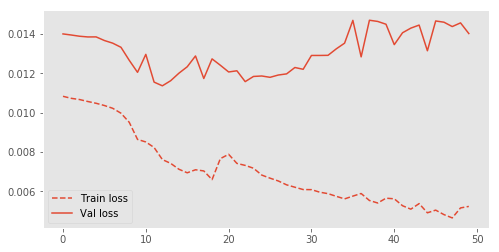

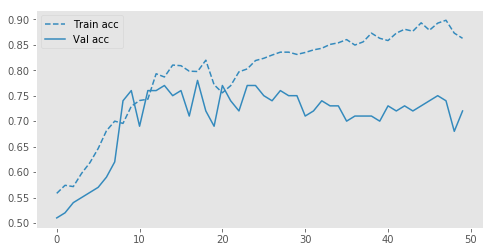

In [42]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

### Etc

In [ ]:
train_input_var = Variable(train_input.cuda())
train_target_var = Variable(train_target.cuda(), requires_grad=False)

test_input_var = Variable(test_input.cuda())
test_target_var = Variable(test_target.cuda(), requires_grad=False)

In [ ]:
pred_test = best_model(test_input_var).data
pred_test_classes = pred_test.max(1)[1]
accuracy_score(pred_test_classes, test_target)

In [ ]:
pred_train = best_model(train_input_var).data
pred_train_classes = pred_train.max(1)[1]
accuracy_score(pred_train_classes, train_target)